In [2]:
import xarray as xr
import flox.xarray as fx
import numpy as np
import pandas as pd
import cmocean.cm as cmo
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [3]:
ds_globe = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/new_test.nc', chunks={'N_PROF':10000})

In [5]:
unique_prof = np.arange(len(ds_globe['N_PROF']))
ds_globe = ds_globe.assign_coords(N_PROF=('N_PROF', unique_prof))
ds_so = ds_globe.where(ds_globe.LATITUDE.compute()<-30, drop=True)

In [7]:
def get_ds_binned(ds, lon_bins, lat_bins):
    """
    Bin an xarray Dataset by 3-degree latitude and longitude bins,
    replacing Interval dimensions with bin centers.
    
    Parameters:
        ds : xarray.Dataset
            The dataset to bin.
        lon_bins : array-like
            Bin edges for longitude (e.g. np.arange(-180, 181, 3))
        lat_bins : array-like
            Bin edges for latitude (e.g. np.arange(-90, 91, 3))
    
    Returns:
        xarray.Dataset
            Binned dataset with dimensions (PRES_INTERPOLATED, lon_c, lat_c)
    """

    # Step 1: Bin with fx.xarray_reduce using IntervalIndex
    ds_binned = fx.xarray_reduce(
        ds,
        'LONGITUDE',
        'LATITUDE',
        func='mean',
        expected_groups=(
            pd.IntervalIndex.from_breaks(lon_bins),
            pd.IntervalIndex.from_breaks(lat_bins),
        ),
        fill_value=np.nan,
        skipna=True
    )

    # Step 2: Create left, right, center arrays
    lon_l = np.array(lon_bins[:-1])
    lon_r = np.array(lon_bins[1:])
    lon_c = (lon_l + lon_r) / 2

    lat_l = np.array(lat_bins[:-1])
    lat_r = np.array(lat_bins[1:])
    lat_c = (lat_l + lat_r) / 2

    # Step 3: Replace Interval dims with center dims
    ds_binned = ds_binned.assign_coords({
        "lon_c": ("LONGITUDE", [iv.mid for iv in ds_binned['LONGITUDE'].values]),
        "lat_c": ("LATITUDE", [iv.mid for iv in ds_binned['LATITUDE'].values]),
        "lon_l": ("LONGITUDE", lon_l),
        "lon_r": ("LONGITUDE", lon_r),
        "lat_l": ("LATITUDE", lat_l),
        "lat_r": ("LATITUDE", lat_r),
    })

    ds_binned = ds_binned.swap_dims({"LONGITUDE": "lon_c", "LATITUDE": "lat_c"})

    return ds_binned

**Seasonal Dataset Making**

In [15]:
lon_bins = np.arange(-180,181,1)
so_lat_bins = np.arange(-90,-29,1)

In [9]:
seasonal_groups = ds_so.groupby('TIME.season')

ds_so_binned_seasonal = {
    season: get_ds_binned(group, lon_bins, so_lat_bins)
    for season, group in seasonal_groups
}

In [12]:
ordered_seasons = ["DJF", "MAM", "JJA", "SON"]
season_labels = {
    "DJF": "Summer",
    "MAM": "Autumn",
    "JJA": "Winter",
    "SON": "Spring"
}

In [11]:
depth = 10
given_depth_seasonal = {
    season: ds.sel(PRES_INTERPOLATED=depth, method='nearest')[['SA', 'CT', 'SIG0']].compute()
    for season, ds in ds_so_binned_seasonal.items()
}


/home.ufs/jp4778/.conda/envs/pangeo/lib/python3.10/site-packages/flox/aggregations.py:259: RuntimeWarning: invalid value encountered in divide
  finalize=lambda sum_, count: sum_ / count,
/home.ufs/jp4778/.conda/envs/pangeo/lib/python3.10/site-packages/flox/aggregations.py:259: RuntimeWarning: invalid value encountered in divide
  finalize=lambda sum_, count: sum_ / count,
/home.ufs/jp4778/.conda/envs/pangeo/lib/python3.10/site-packages/flox/aggregations.py:259: RuntimeWarning: invalid value encountered in divide
  finalize=lambda sum_, count: sum_ / count,
/home.ufs/jp4778/.conda/envs/pangeo/lib/python3.10/site-packages/flox/aggregations.py:259: RuntimeWarning: invalid value encountered in divide
  finalize=lambda sum_, count: sum_ / count,


In [13]:
# all_SA = xr.concat([given_depth_seasonal[season].SA for season in ordered_seasons], dim='concat_dim')
# sa_vmin = float(all_SA.quantile(0.05))
# sa_vmax = float(all_SA.quantile(0.95))

# all_CT = xr.concat([given_depth_seasonal[season].CT for season in ordered_seasons], dim='concat_dim')
# ct_vmin = float(all_CT.quantile(0.05))
# ct_vmax = float(all_CT.quantile(0.95))

# all_SIG0 = xr.concat([given_depth_seasonal[season].SIG0 for season in ordered_seasons], dim='concat_dim')
# sig0_vmin = float(all_SIG0.quantile(0.05))
# sig0_vmax = float(all_SIG0.quantile(0.95))

**Regular Dataset**

In [31]:
ds_so_binned = get_ds_binned(ds_so, lon_bins, so_lat_bins)

In [30]:
depth = 10
ds_so_binned_depth = ds_so_binned.sel(PRES_INTERPOLATED=depth, method='nearest')[['SA', 'CT', 'SIG0']].compute()


/home.ufs/jp4778/.conda/envs/pangeo/lib/python3.10/site-packages/flox/aggregations.py:259: RuntimeWarning: invalid value encountered in divide
  finalize=lambda sum_, count: sum_ / count,


In [38]:
g_so_min = float(ds_so_binned_depth.SA.quantile(0.05))
g_so_max = float(ds_so_binned_depth.SA.quantile(0.95))

Text(0.5, 1.0, 'Average Salinity in Southern Ocean at Depth of 10m')

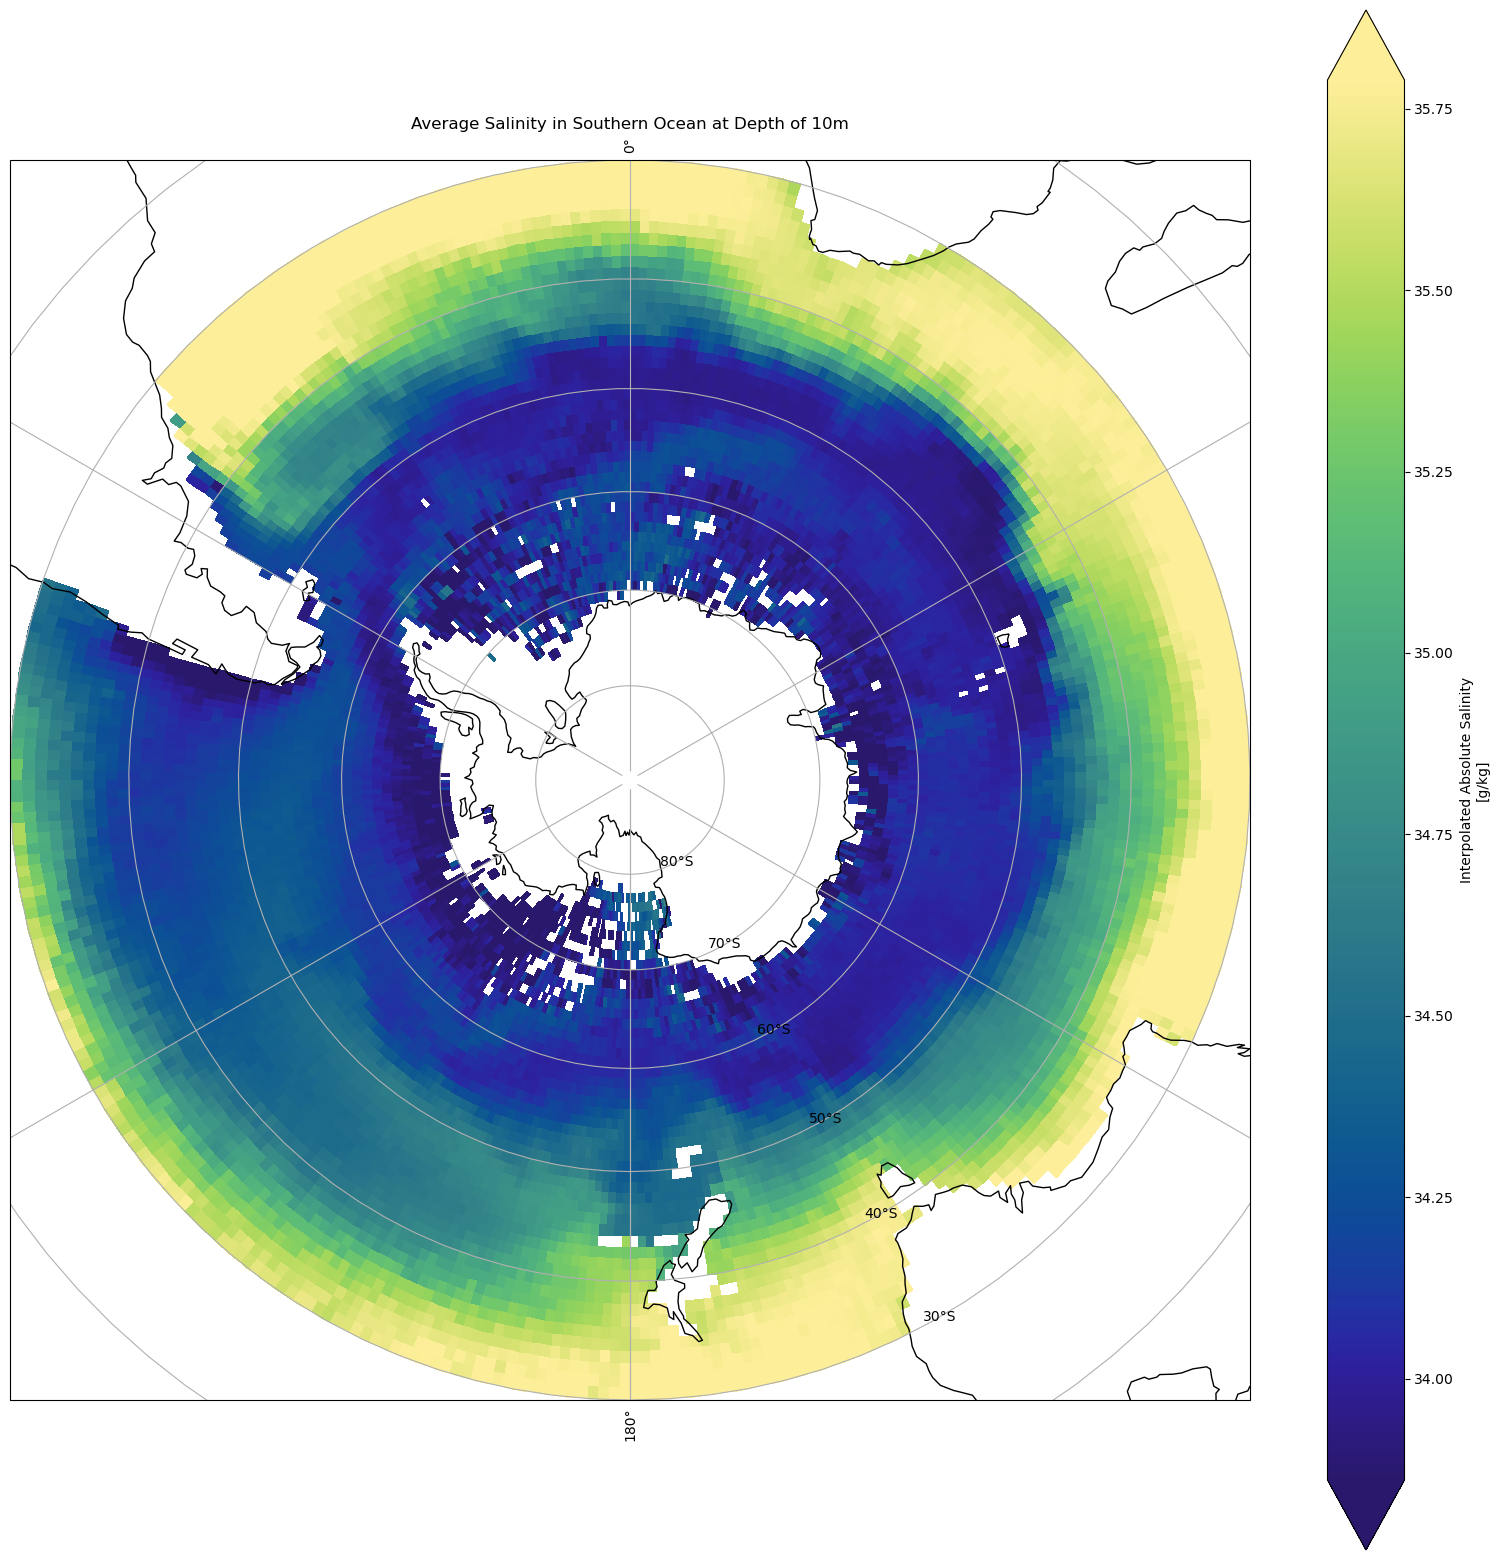

In [51]:
fig = plt.figure(figsize=(20,20))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.coastlines()
ax.gridlines(draw_labels = True)
ds_so_binned_depth.SA.plot(x = 'lon_c',
                           y ='lat_c',
                           transform = ccrs.PlateCarree(),
                           robust = True, infer_intervals = True,
                           cmap = cmo.haline,
                           vmin = g_so_min,
                           vmax = g_so_max)
plt.title('Average Salinity in Southern Ocean at Depth of 10m')

**Salinity Seasonal Anomaly**

In [75]:
seasonal_SA_anomalies = {
    season: ds.SA - ds_so_binned_depth.SA
    for season, ds in given_depth_seasonal.items()
}

all_SA_anom = xr.concat([seasonal_SA_anomalies[season] for season in ordered_seasons], dim='concat_dim')
vmin_raw = float(all_SA_anom.quantile(0.05))
vmax_raw = float(all_SA_anom.quantile(0.95))

abs_max = max(abs(vmin_raw), abs(vmax_raw))
vmin, vmax = -abs_max, abs_max

/tmp/ipykernel_26531/3750028816.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


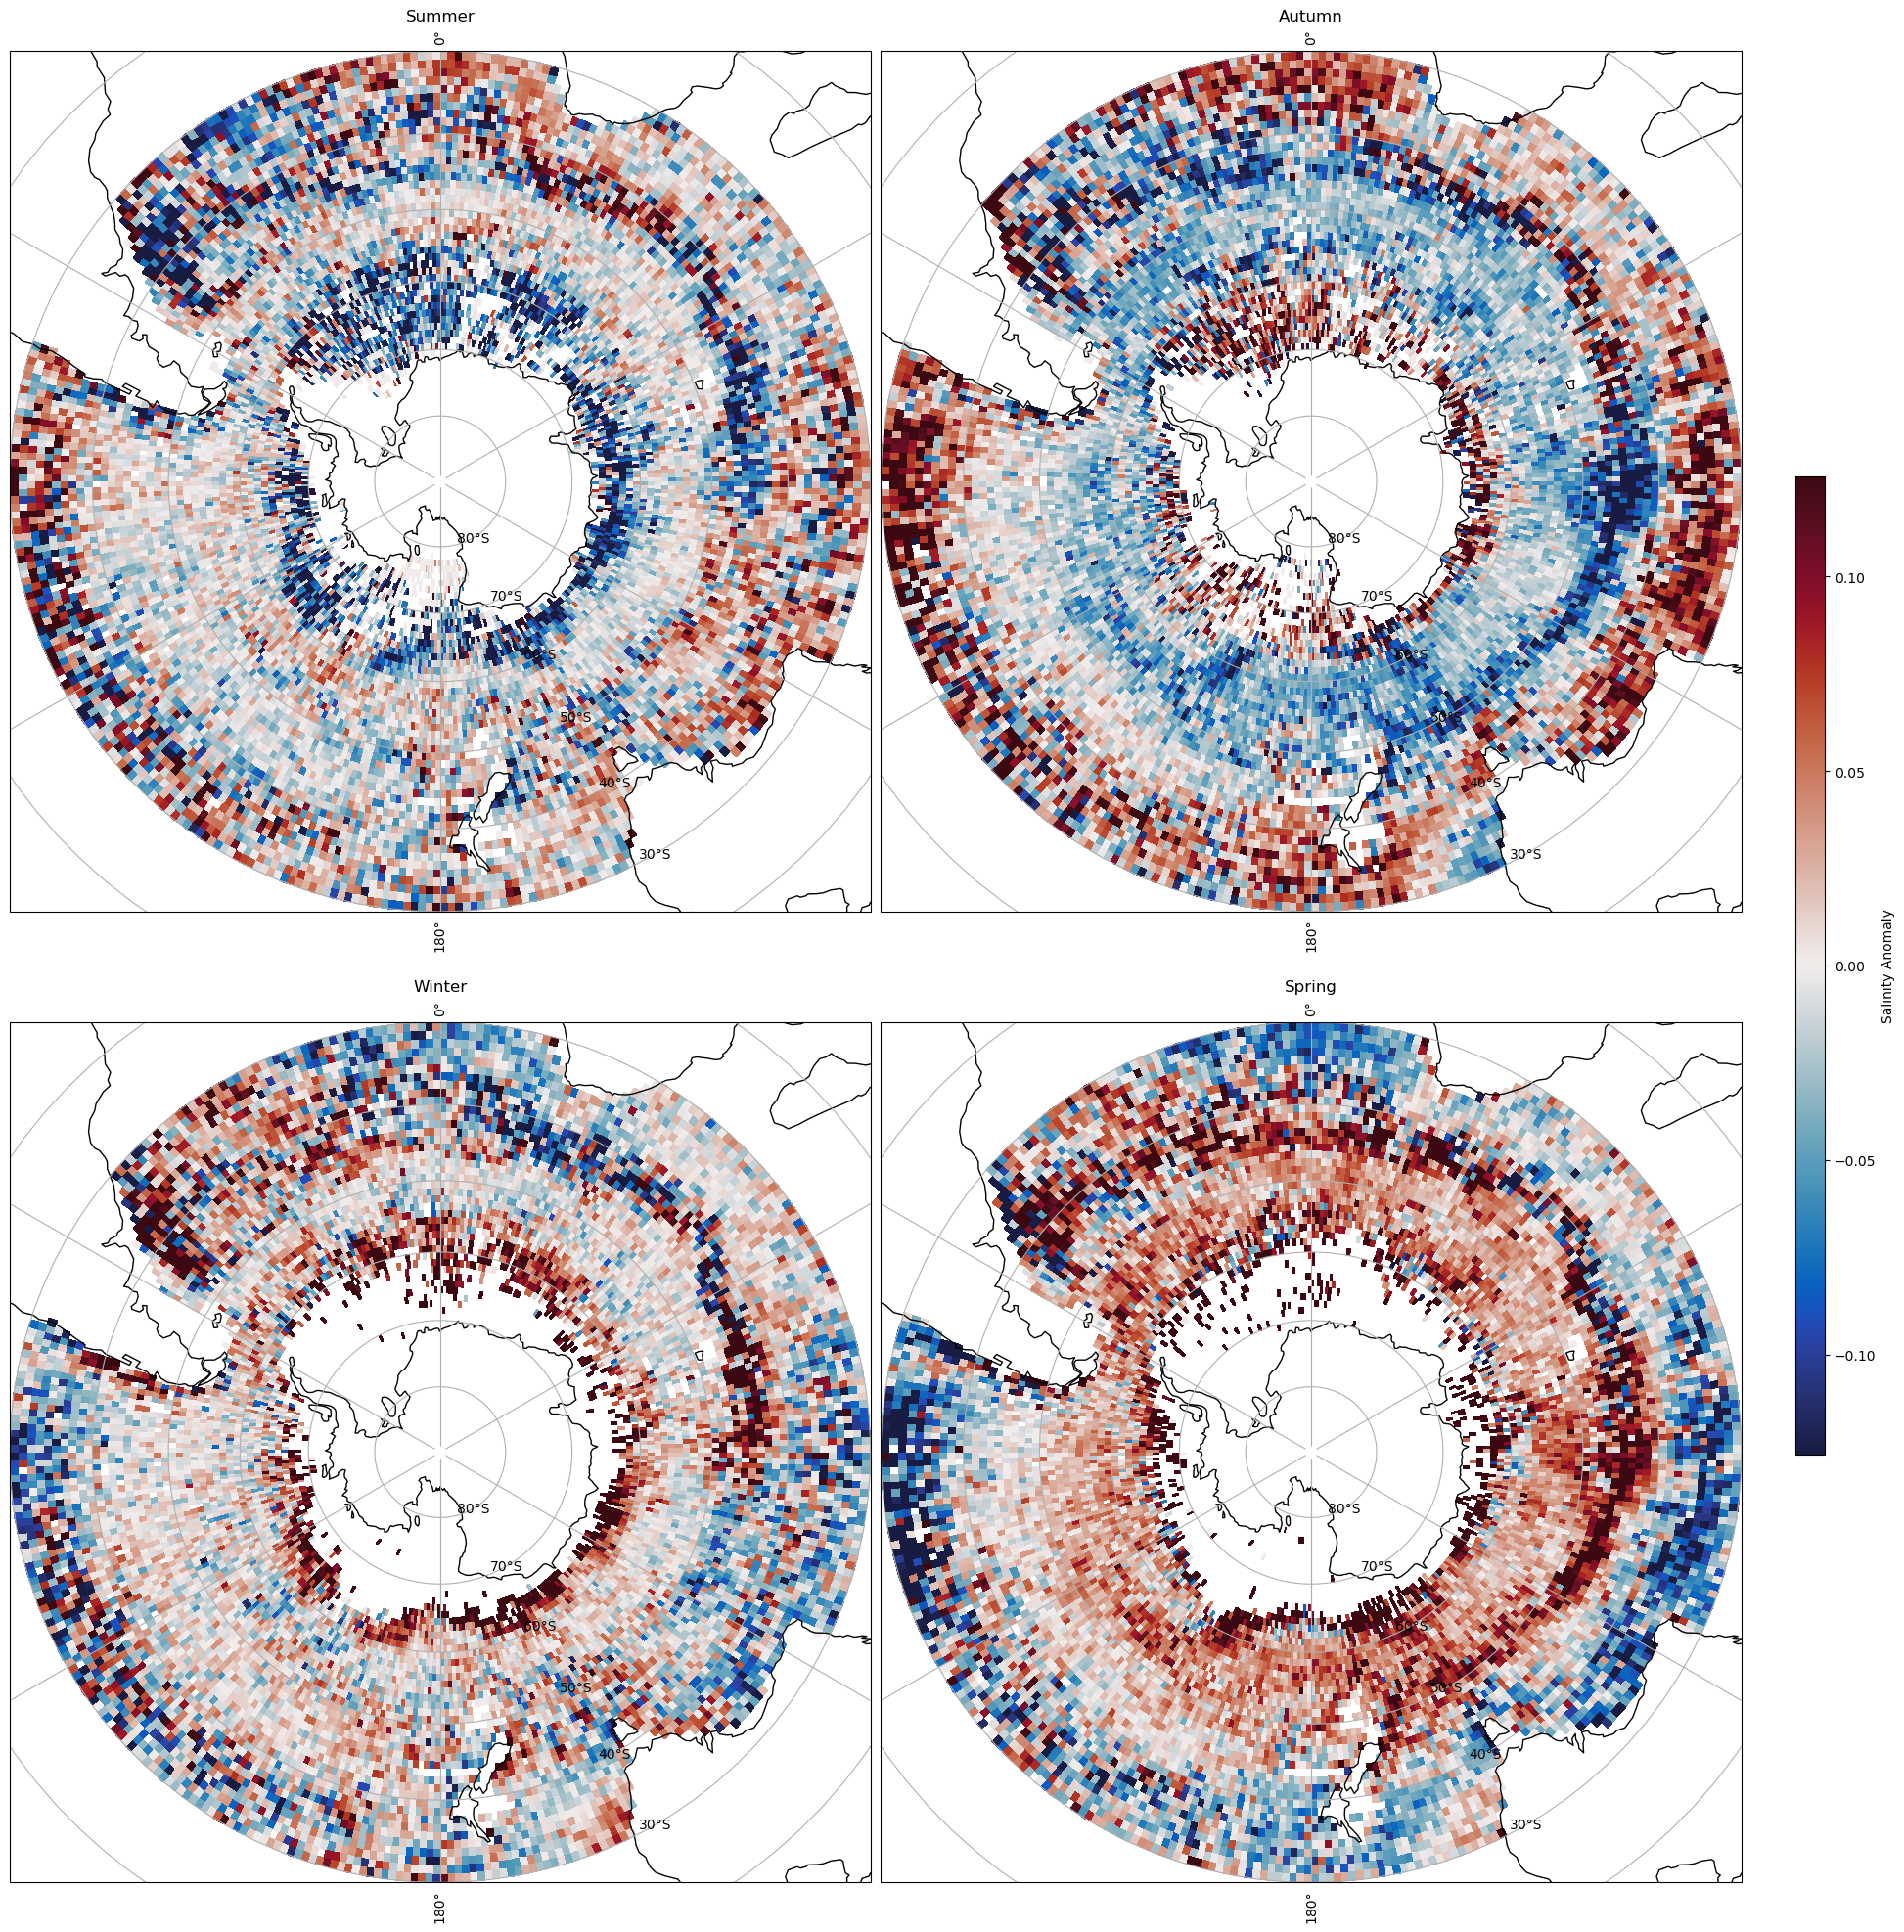

In [80]:
fig, axs = plt.subplots(2, 2, figsize=(20, 20), 
                        subplot_kw={'projection': ccrs.SouthPolarStereo()})
axs = axs.ravel()

for i, season in enumerate(ordered_seasons):
    ds = seasonal_SA_anomalies[season]
    ax = axs[i]
    ax.coastlines()
    ax.gridlines(draw_labels=True)

    # Plot with consistent color limits
    ds.plot(
        ax=ax,
        x='lon_c',
        y='lat_c',
        transform=ccrs.PlateCarree(),
        vmin=vmin,
        vmax=vmax,
        cmap=cmo.balance,
        add_colorbar=False
    )
    ax.set_title(season_labels[season])
    
cbar_ax = fig.add_axes([0.92, 0.25, 0.015, 0.5])
plt.colorbar(axs[0].collections[0], cax=cbar_ax, label="Salinity Anomaly")

plt.tight_layout(rect=[0, 0, 0.9, 1])